HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

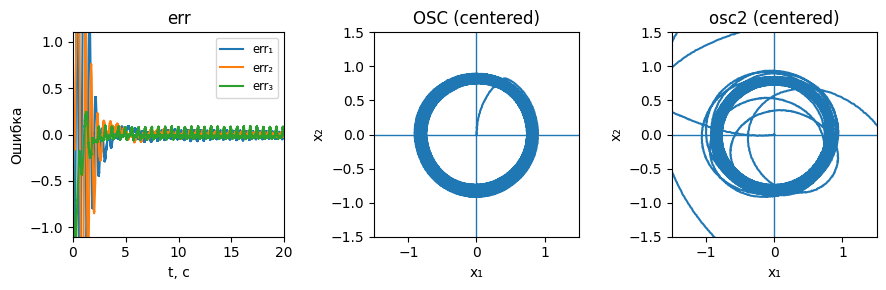

In [7]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
model = nengo.Network()


tau_synapse = 0.1
omega = 10

with model:
    speed = nengo.Ensemble(n_neurons=500, dimensions=1)
    stim_speed = nengo.Node(1)
    nengo.Connection(stim_speed, speed)
    osc = nengo.Ensemble(n_neurons=500, dimensions=3, radius=2)
    osc2 = nengo.Ensemble(n_neurons=500, dimensions=3, radius=2)
    err = nengo.Ensemble(n_neurons=500, dimensions=3, radius=2)

    def recurrent(x):
        return [-tau_synapse*x[2]*omega*x[1]+x[0], tau_synapse*x[2]*omega*x[0]+x[1]]
    
    nengo.Connection(osc, osc[:2], function=recurrent, synapse=tau_synapse)
    
    def stim_func(t):
        if t < 0.1:
            return 1, 0
        else:
            return 0, 0
        
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, osc[:2])
    nengo.Connection(speed, osc[2]) 
    
    nengo.Connection(osc2, osc2[:2], function=recurrent, synapse=tau_synapse)
    nengo.Connection(osc, err, transform=-1)
    nengo.Connection(osc2, err)
    a = nengo.Connection(err, osc2, learning_rule_type=nengo.PES())
    nengo.Connection(err, a.learning_rule)

    p_osc  = nengo.Probe(osc,  synapse=0.1)
    p_osc2 = nengo.Probe(osc2, synapse=0.1)
    p_err  = nengo.Probe(err,  synapse=0.1)

with nengo.Simulator(model, dt=0.001) as sim:
    sim.run(20.0)   # прогоняем 5 секунд

# 2. Извлечение данных
t         = sim.trange()         # (N,)
data_osc  = sim.data[p_osc]      # (N,3)
data_osc2 = sim.data[p_osc2]     # (N,3)
data_err  = sim.data[p_err]      # (N,3)

# 6. Рисуем три панели
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# 6.1 Ошибка err(t)
ax = axes[0]
ax.plot(t, data_err[:,0], label='err₁')
ax.plot(t, data_err[:,1], label='err₂')
ax.plot(t, data_err[:,2], label='err₃')
ax.set_title('err')
ax.set_xlabel('t, с')
ax.set_ylabel('Ошибка')
ax.set_xlim(0, t[-1])
ax.set_ylim(-1.1, 1.1)
ax.legend(loc='upper right', fontsize='small')

# 6.2 OSC (centered)
ax = axes[1]
ax.plot(data_osc[:,1], data_osc[:,0])
ax.set_title('OSC (centered)')
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)
ax.set_aspect('equal','box')
ax.set_xlim(-1.5, 1.5); ax.set_ylim(-1.5, 1.5)

# 6.3 osc2 (centered)
ax = axes[2]
ax.plot(data_osc2[:,0], data_osc2[:,1])
ax.set_title('osc2 (centered)')
ax.set_xlabel('x₁'); ax.set_ylabel('x₂')
ax.axhline(0, linewidth=1) 
ax.axvline(0, linewidth=1)
ax.set_aspect('equal','box')
ax.set_xlim(-1.5,1.5); ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

